In [2]:
#import libraries for machine learning
import pandas as pd
from pandas_datareader import data as pdr
from darts import TimeSeries
from darts.models import ExponentialSmoothing
import matplotlib.pyplot as plt
from darts.models import RNNModel, NBEATSModel, BlockRNNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.models import Prophet, ARIMA, StatsForecastAutoARIMA, VARIMA
import datetime as dt
import yfinance as yf
yf.pdr_override()
plt.rcParams['figure.figsize'] = [20, 4]

/home/malthe/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# plt.rcParams['figure.figsize'] = [20, 4]

# Get Bitcoin data from API
date_start = dt.datetime(2018, 5, 1)
date_end = dt.datetime(2023, 5, 1)

df = pdr.get_data_yahoo('BTC-USD', date_start, date_end)

# Reset the index and create a new 'Date' column
df.reset_index(inplace=True)

# Create time series object
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-01,9251.469727,9255.879883,8891.049805,9119.009766,9119.009766,7713019904
1,2018-05-02,9104.599609,9256.519531,9015.139648,9235.919922,9235.919922,7558159872
2,2018-05-03,9233.969727,9798.330078,9188.150391,9743.860352,9743.860352,10207299584
3,2018-05-04,9695.500000,9779.200195,9585.959961,9700.759766,9700.759766,8217829888
4,2018-05-05,9700.280273,9964.500000,9695.120117,9858.150391,9858.150391,7651939840


In [53]:
#crate a time series object
ts_close = TimeSeries.from_dataframe(df, 'Date', 'Close')
ts_open = TimeSeries.from_dataframe(df, 'Date', 'Open')
ts_high = TimeSeries.from_dataframe(df, 'Date', 'High')
ts_low = TimeSeries.from_dataframe(df, 'Date', 'Low')
ts_volume = TimeSeries.from_dataframe(df, 'Date', 'Volume')

# create multivariate time series
ts_multivariate = TimeSeries.from_dataframe(df, 'Date', ['Open', 'High', 'Low', 'Close'])

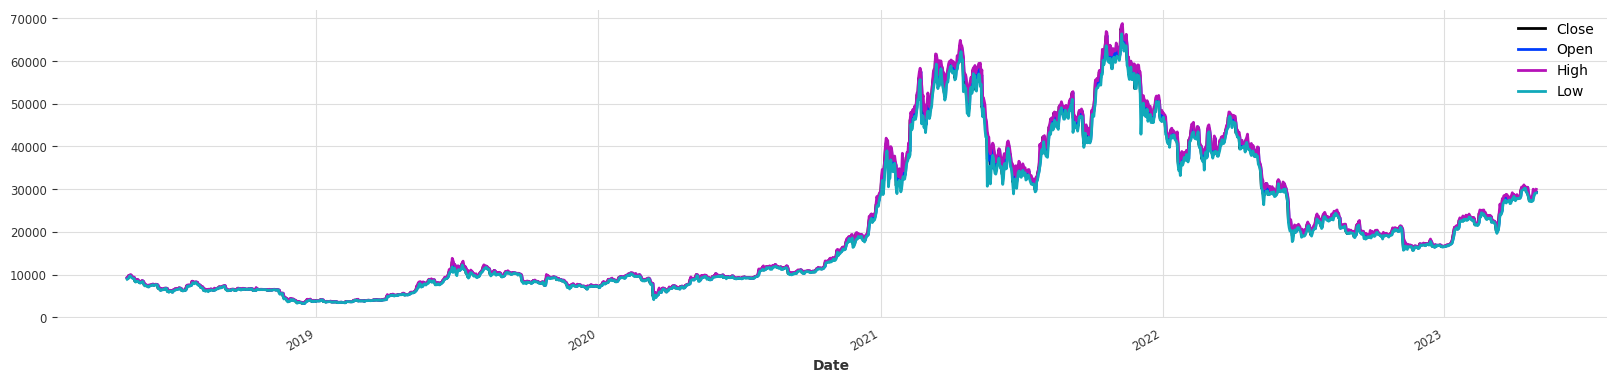

In [5]:
ts_close.plot(label='Close')
ts_open.plot(label='Open')
ts_high.plot(label='High')
ts_low.plot(label='Low')
plt.legend(loc='best')
plt.show()

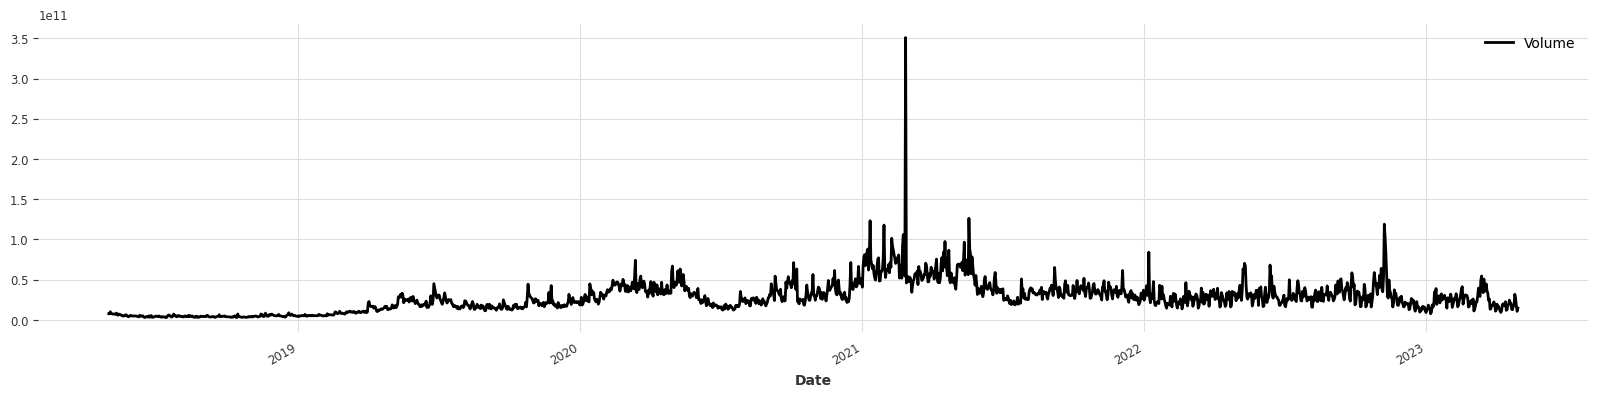

In [6]:
ts_volume.plot(label='Volume')

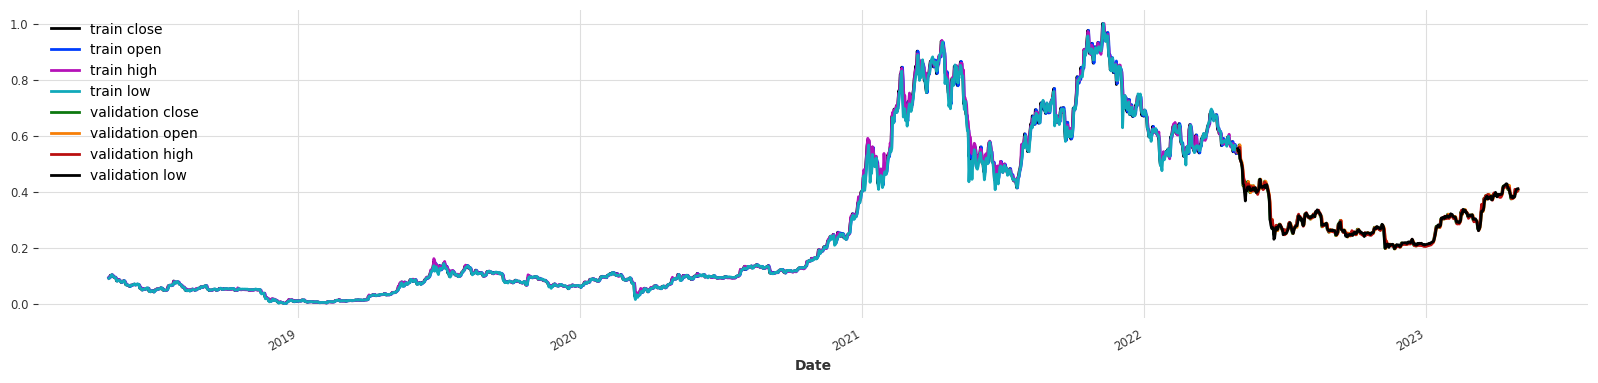

In [54]:
# preproccessing
scalar_close, scalar_open, scalar_high, scalar_low, scalar_volume = Scaler(), Scaler(), Scaler(), Scaler(), Scaler()
ts_close_scaled = scalar_close.fit_transform(ts_close)
ts_open_scaled = scalar_open.fit_transform(ts_open)
ts_high_scaled = scalar_high.fit_transform(ts_high)
ts_low_scaled = scalar_low.fit_transform(ts_low)
ts_volume_scaled = scalar_volume.fit_transform(ts_volume)


split_date = '2022-05-01'
# make train and validation set
train_close, val_close = ts_close.split_after(pd.Timestamp(split_date))
train_open, val_open = ts_open.split_after(pd.Timestamp(split_date))
train_high, val_high = ts_high.split_after(pd.Timestamp(split_date))
train_low, val_low = ts_low.split_after(pd.Timestamp(split_date))
train_volume, val_volume = ts_volume.split_after(pd.Timestamp(split_date))
train_multi, val_multi = ts_multivariate.split_after(pd.Timestamp(split_date))

# make scaled train and validation set
train_close_sc, val_close_sc = ts_close_scaled.split_after(pd.Timestamp(split_date))
train_open_sc, val_open_sc = ts_open_scaled.split_after(pd.Timestamp(split_date))
train_high_sc, val_high_sc = ts_high_scaled.split_after(pd.Timestamp(split_date))
train_low_sc, val_low_sc = ts_low_scaled.split_after(pd.Timestamp(split_date))
train_volume_sc, val_volume_sc = ts_volume_scaled.split_after(pd.Timestamp(split_date))


# plot scaled train and validation set
train_close_sc.plot(label='train close')
train_open_sc.plot(label='train open')
train_high_sc.plot(label='train high')
train_low_sc.plot(label='train low')

val_close_sc.plot(label='validation close')
val_open_sc.plot(label='validation open')
val_high_sc.plot(label='validation high')
val_low_sc.plot(label='validation low')

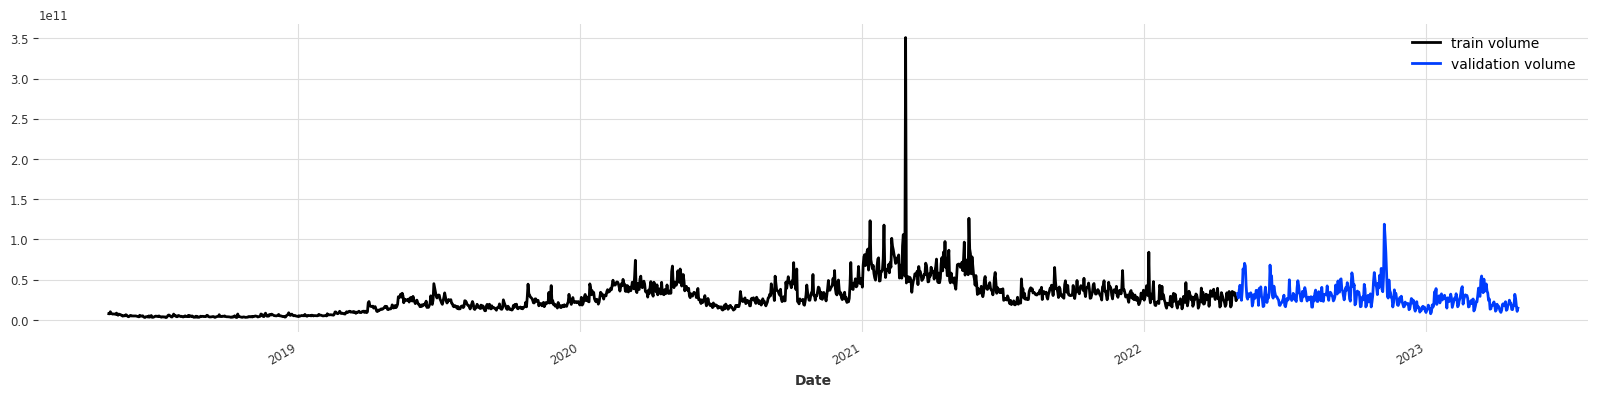

In [8]:
train_volume.plot(label='train volume')
val_volume.plot(label='validation volume')

In [9]:
# train LSTM model
model_lstm = BlockRNNModel(
    model='LSTM',
    input_chunk_length=100,
    output_chunk_length =25,
    hidden_dim=64,
    n_rnn_layers=2,
    n_epochs=100,
    dropout=0.2,
    batch_size=32,
    lr=0.001,
    
    pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]}
)
model_lstm.fit(series=[train_close_sc, train_open_sc, train_high_sc, train_low_sc], val_series=[val_close_sc, val_open_sc, val_high_sc, val_low_sc])
# , train_volume

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 650   
---------------------------------------------------
3.5 K     Trainable params
0         Non-traina

Epoch 9: 100%|██████████| 168/168 [00:02<00:00, 83.66it/s, train_loss=0.00152] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 168/168 [00:02<00:00, 83.63it/s, train_loss=0.00152]


In [10]:
# make the prediction using LSTM
future_lstm = model_lstm.predict(n=len(val_close_sc), series=train_close_sc)
future_lstm = scalar_close.inverse_transform(future_lstm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.21it/s]


MAPE = 104.94%


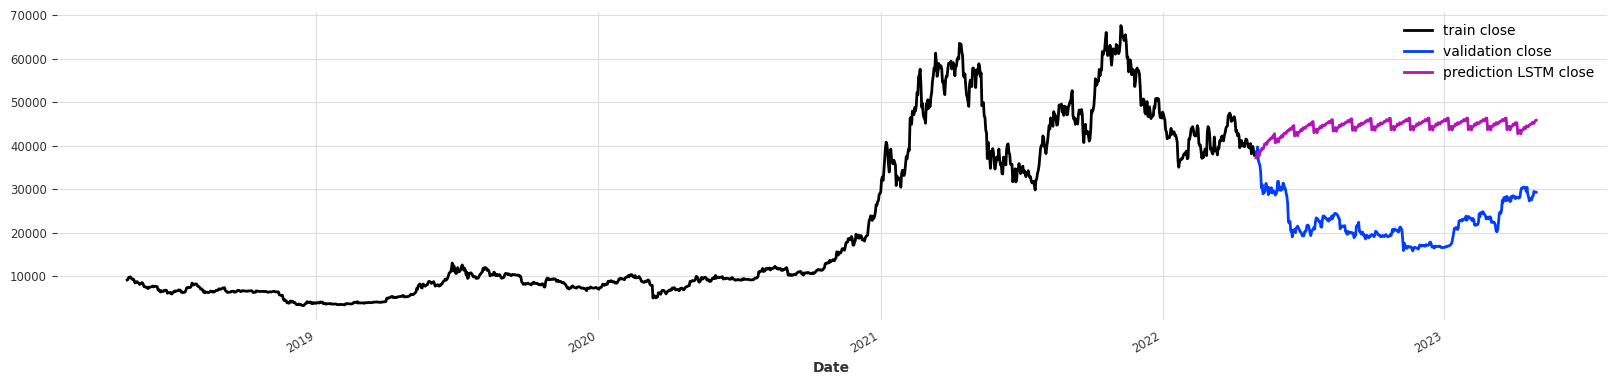

In [11]:
# plot the prediction 
train_close.plot(label='train close')
val_close.plot(label='validation close')
future_lstm.plot(label='prediction LSTM close')
plt.legend()
print("MAPE = {:.2f}%".format(mape(val_close, future_lstm)))

14:47:17 - cmdstanpy - INFO - Chain [1] start processing
14:47:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 84.12%


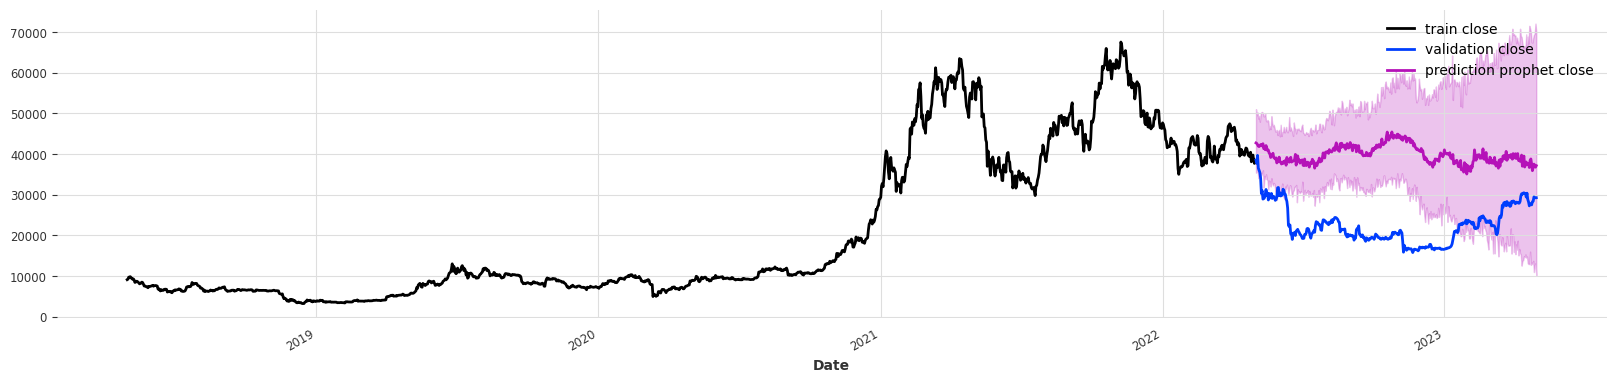

In [12]:
# make prophet model
model_prophet = Prophet()
model_prophet.fit(train_close_sc)

# make the prediction using prophet
future_prophet = model_prophet.predict(n=len(val_close), num_samples=100)
future_prophet = scalar_close.inverse_transform(future_prophet)

# plot the prediction
train_close.plot(label='train close')
val_close.plot(label='validation close')
future_prophet.plot(label='prediction prophet close')
plt.legend()
print("MAPE = {:.2f}%".format(mape(val_close, future_prophet)))

In [55]:
# make ARIMA model
model_arima = ARIMA()
param_grid = {'p': [5, 4, 3, 2, 1], 'd': [2, 1, 0], 'q': [4, 3, 2, 1]}
best_params = model_arima.gridsearch(param_grid, series=train_close, val_series=val_close)

# initialize ARIMA model with best parameters
print(best_params[1])
model_arima = ARIMA(p=best_params[1]['p'], d=best_params[1]['d'], q=best_params[1]['q']) #, trend=best_params[1]['trend']
model_arima.fit(train_close)

/home/malthe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/malthe/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/malthe/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/malthe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/malthe/.local/lib/python3.10/site-p

{'p': 4, 'd': 0, 'q': 1}


MAPE = 51.06%


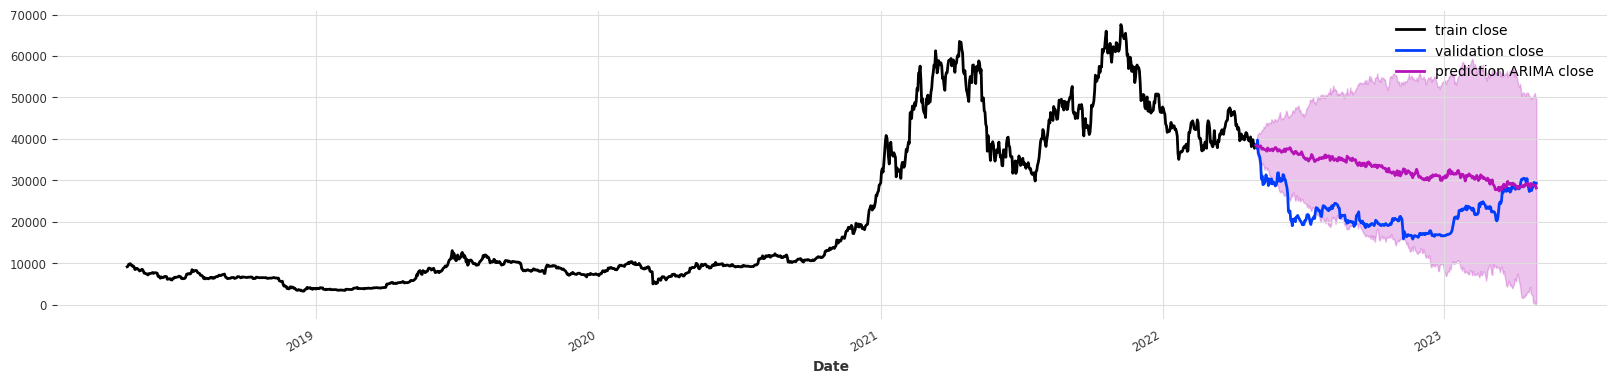

In [56]:
# make the prediction using ARIMA
future_arima = model_arima.predict(n=len(val_close), num_samples=100)

# future_arima = future_arima.inverse_transform(scalar_close)
# plot the prediction
train_close.plot(label='train close')
val_close.plot(label='validation close')
future_arima.plot(label='prediction ARIMA close')
plt.legend()
print("MAPE = {:.2f}%".format(mape(val_close, future_arima)))

In [57]:
# make VARIMA model
model_varima = VARIMA()
param_grid = {'p': [3, 1], 'd': [1, 0], 'q': [2, 1, 0]} # 'trend': ['n', 'c', 'ct', 't']
best_params = model_varima.gridsearch(param_grid, series=train_multi, val_series=val_multi)

# initialize VARIMA model with best parameters
print(best_params[1])
model_varima = VARIMA(p=best_params[1]['p'], d=best_params[1]['d'], q=best_params[1]['q']) #, trend=best_params[1]['trend']
model_varima.fit(train_multi)

/home/malthe/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/malthe/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/malthe/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/malthe/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  w

{'p': 1, 'd': 0, 'q': 1}


ValueError: This model only supports univariate TimeSeries instances

covariance is not positive-semidefinite.


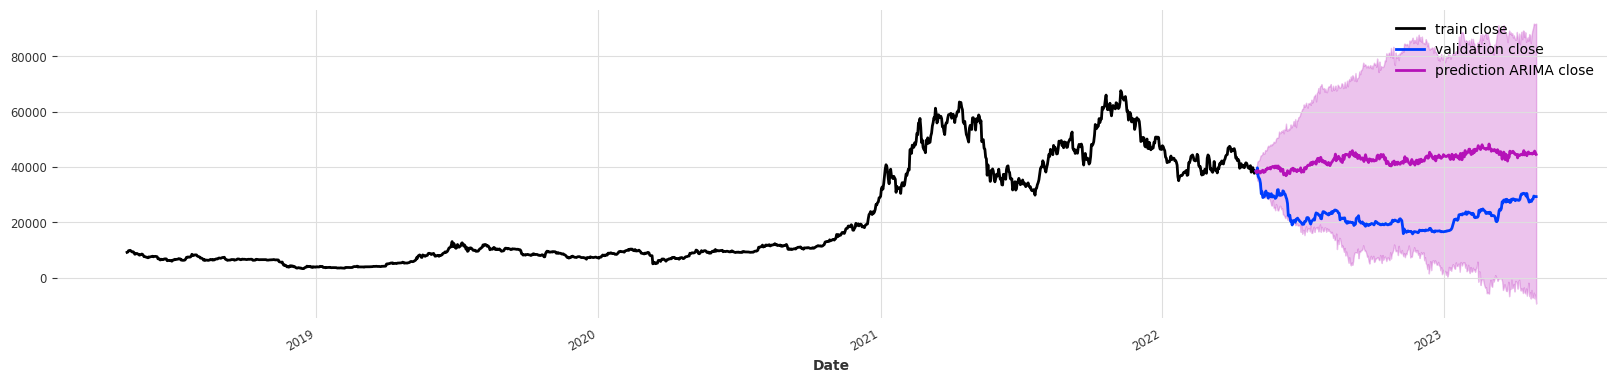

In [ ]:
# make the prediction using ARIMA
future_varima = model_varima.predict(n=len(val_close), num_samples=100)
# future_arima = future_arima.inverse_transform(scalar_close)

# plot the prediction
train_close.plot(label='train close')
val_close.plot(label='validation close')
future_varima['Close'].plot(label='prediction VARIMA close')
plt.legend()
print("MAPE = {:.2f}%".format(mape(val_close, future_varima['Close'])))

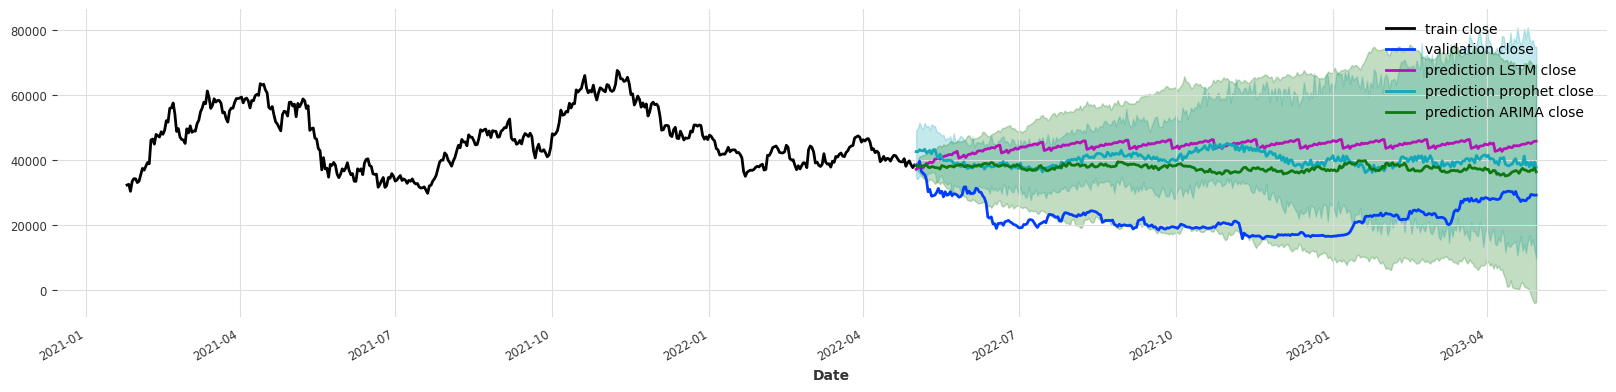

In [ ]:
train_close[1000:].plot(label='train close')
val_close.plot(label='validation close')

future_arima = model_arima.predict(n=len(val_close))
future_varima = model_varima.predict(n=len(val_close))
future_lstm = model_lstm.predict(n=len(val_close))
future_prophet = model_prophet.predict(n=len(val_close))

future_lstm.plot(label='prediction LSTM close')
future_prophet.plot(label='prediction prophet close')
future_arima.plot(label='prediction ARIMA close')
future_varima.plot(label='prediction VARIMA close')